# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
import os
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [19]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

# meta = data_info[(data_info.paradigm == 'grating') & ((data_info.area == 'LM') | (data_info.area == 'LI'))]
meta = data_info[(data_info.paradigm == 'grating') & (data_info.area == 'LM')]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta

LM    23
Name: area, dtype: int64 23


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200721,LM,200.0,2,NaN,True,grating,6s,1.0,NaN
1,1324,200729,LM,200.0,3,NaN,True,grating,6s,1.0,NaN
2,1322,200804,LM,200.0,3,NaN,True,grating,6s,1.0,NaN
3,1328,201119,LM,200.0,3,NaN,True,grating,6s,1.0,NaN
4,1328,201127,LM,200.0,2,NaN,True,grating,6s,1.0,NaN
5,1329,201217,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN
6,1329,201217,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN
7,1337,210127,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN
8,1337,210127,LM,150.0,3,1.0,NaN,grating,6s,NaN,NaN
9,1338,210325,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN


# df tidy for 1 set
grat 8ori 3isi

In [22]:
iset = 20

mouse = meta.loc[iset, 'mouse'].astype(str)
date = meta.loc[iset, 'date'].astype(str)
area = meta.loc[iset, 'area']
print(mouse, date, area)

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
for dirname in os.listdir(dir_data):
    if mouse in dirname and date in dirname:
        dir_data = dir_data + dirname
        break

stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=True)
# if np.min(stim_id[0]) == 1: # stim id was 1-based index
#     stim_id[0] -= 1 # stim id adjusted to 0-based index
# assert np.min(stim_id[0]) == 0
stim_id.keys(), trace_by_trial.shape

1381 230307 LM
ncell: 87, nstim: 1, ntrial: 500, nframe: 207


(dict_keys(['stim_ori', 'isi_nframe', 'adapter_contrast']), (87, 500, 207))

trace_cell_avg: (207,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (207,)


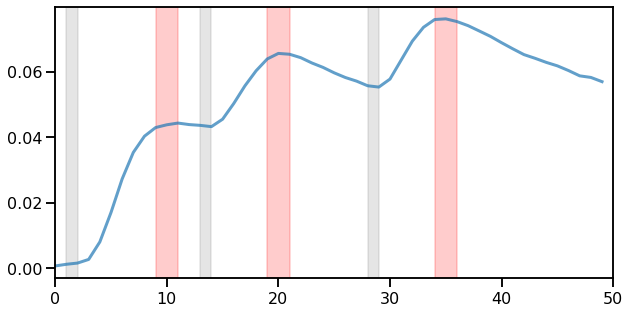

In [26]:
## find resp window
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

base1_frame = 1
resp_ad_frame = 9
base2_frame = 13
resp_tg250_frame = 19
base3_frame = 28
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')
plt.xlim(0, 50);

In [27]:
## get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
resp_tg250 = resp_tg250 - base2

base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
resp_tg750 = resp_tg750 - base3

resp_ad.shape, resp_tg250.shape, resp_tg750.shape

((87, 500), (87, 500), (87, 500))

In [28]:
stim_id['stim_ori']

array([[ 67.5],
       [135. ],
       [112.5],
       [135. ],
       [ 22.5],
       [112.5],
       [ 67.5],
       [ 67.5],
       [112.5],
       [ 90. ],
       [135. ],
       [ 45. ],
       [112.5],
       [ 45. ],
       [157.5],
       [112.5],
       [ 22.5],
       [  0. ],
       [135. ],
       [112.5],
       [135. ],
       [ 67.5],
       [ 67.5],
       [  0. ],
       [  0. ],
       [ 90. ],
       [157.5],
       [  0. ],
       [ 22.5],
       [ 45. ],
       [ 90. ],
       [ 90. ],
       [  0. ],
       [ 45. ],
       [ 22.5],
       [  0. ],
       [135. ],
       [135. ],
       [ 67.5],
       [157.5],
       [ 22.5],
       [ 67.5],
       [ 45. ],
       [ 67.5],
       [157.5],
       [ 90. ],
       [157.5],
       [ 45. ],
       [ 22.5],
       [ 45. ],
       [ 45. ],
       [ 45. ],
       [157.5],
       [ 22.5],
       [  0. ],
       [112.5],
       [ 90. ],
       [157.5],
       [112.5],
       [157.5],
       [135. ],
       [ 67.5],
       [